In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from skimage import color
from torch.utils.tensorboard import SummaryWriter
print("Torch version: "+str(torch.__version__))
print("Current device: "+str(torch.cuda.current_device()))
print("Is cuda available? "+str(torch.cuda.is_available()))

if torch.cuda.is_available():
    device =torch.device('cuda')
    print("Running on the GPU")
else:
    device=torch.device("cpu")
    print("Running on the CPU")

Torch version: 1.4.0
Current device: 0
Is cuda available? True
Running on the GPU


#### Import data from .pt

In [9]:
batch_size=100
lr=0.001

def load_pt(directory,typ):
    if typ=="train":
        train_data=torch.load(directory)
        return len(train_data),torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    else:
        test_data= torch.load(directory)
        return len(test_data),torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

def viz_a_batch(images):
    print(images.shape)
    images=images.reshape(batch_size,1,images.shape[3],images.shape[3])
    print(images.shape)
    grid=torchvision.utils.make_grid(images,nrow=10)
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(grid,(1,2,0)))
    plt.show()   
    
def sample_from_batch(images):
    images=images.reshape(batch_size,1,images.shape[3],images.shape[3])
    return images[50][0],images[0][0].shape

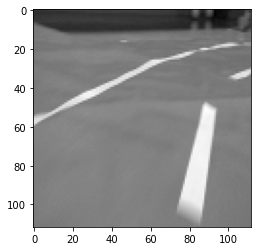

49114


In [10]:
data_len,d_loader=load_pt("D:/git/jetracer/set_4/pt_acc/set_4_train_rsz_withacc.pt","train") # either train or test (to save RAM)
images,acc,labels=next(iter(d_loader))
sample,img_shape=sample_from_batch(images)
plt.imshow(sample,cmap='gray')
plt.show()
print(data_len)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 112, 1, 112])
torch.Size([100, 1, 112, 112])


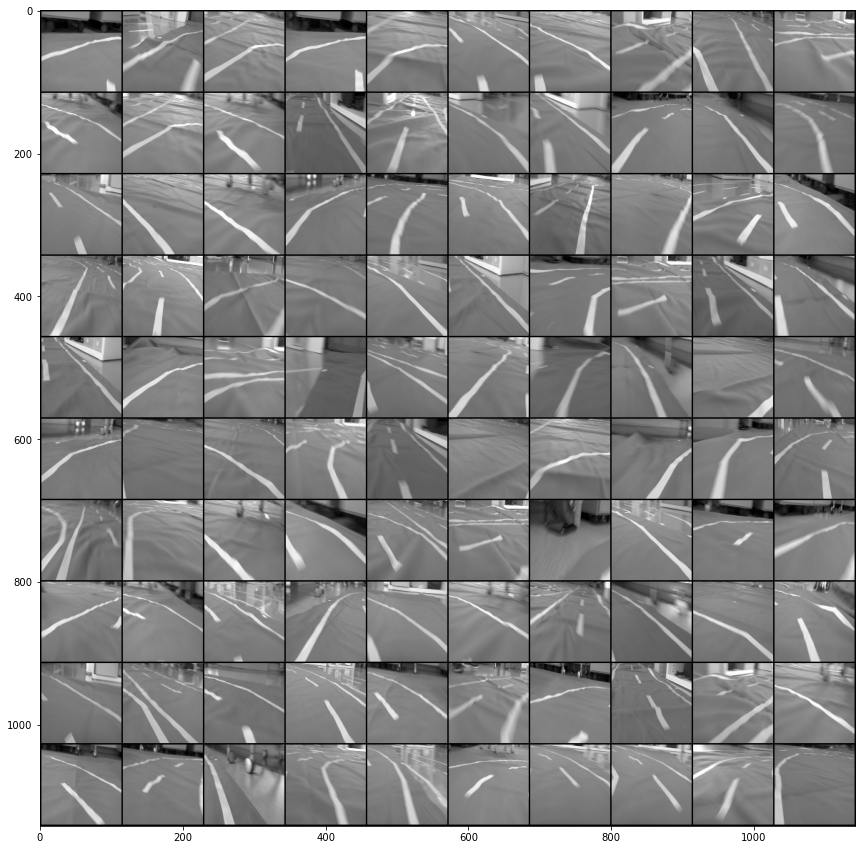

In [4]:
viz_a_batch(images)

#### Model

In [8]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = nn.LayerNorm(normalized_shape=(img_shape))
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=24, kernel_size=3,stride=2)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=36, kernel_size=3,stride=1)
        self.conv3 = nn.Conv2d(in_channels=36, out_channels=48, kernel_size=3,stride=1)
        self.conv4 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.drop=nn.Dropout(0.5)

        self.fc1 = nn.Linear(in_features=64*6*6, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=500)
        self.fc3 = nn.Linear(in_features=500, out_features=100)
        self.fc4 = nn.Linear(in_features=100, out_features=10)
        self.out = nn.Linear(in_features=10, out_features=1)

    def forward(self, t):
        t=self.norm(t.float())
        self.nor=t
        
        t = F.elu(self.conv1(t.float()))
        t = F.max_pool2d(t, kernel_size=2)
        self.c1=t
        
        
        t = F.elu(self.conv2(t))
        t = F.max_pool2d(t, kernel_size=2)
        self.c2=t
        
        
        t = F.elu(self.conv3(t))
#         t = F.max_pool2d(t, kernel_size=2)
        self.c3=t


        t = F.elu(self.conv4(t))
        self.c4=t
        t = F.elu(self.conv5(t))
        self.c5=t
#         self.t=t
#         print(t.shape)
        
        t=self.drop(t)
        t=t.reshape(-1,t.shape[1]*t.shape[2]*t.shape[3])
        t=F.elu(self.fc1(t))
        t=F.elu(self.fc2(t))
        t=F.elu(self.fc3(t))
        t=F.elu(self.fc4(t))
        t=self.out(t)
        return t

network = Network().to(device)
print("T. no. of param: "sum(p.numel() for p in network.parameters() if p.requires_grad))

#### Single image prediction

In [18]:
network = Network().to(device)
sample=sample.unsqueeze(0).unsqueeze(0).to(device)
pred= network(sample)

#### Featur map vizualization

In [ ]:
network = Network()
network.load_state_dict(torch.load('D:/git/jetracer/set_3/set_3_models/steer_set5_18ep_100_0.0001_rsz_pt4.pth'))
sample=sample.unsqueeze(0).unsqueeze(0)
pred= network(sample)

In [11]:
def viz(feature_map):
    image=torch.Tensor.cpu(feature_map).detach().numpy()
    shape=image.shape
    image=image.reshape(shape[1],1,shape[2],shape[3])
    image=torch.tensor(image)
    grid=torchvision.utils.make_grid(image,nrow=10)
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(grid,(1,2,0)))
    plt.show()    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


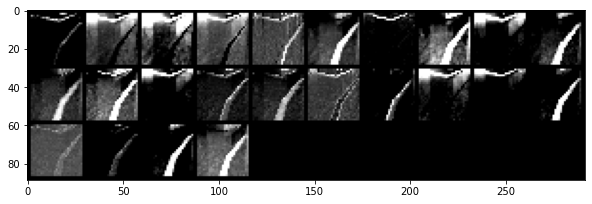

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


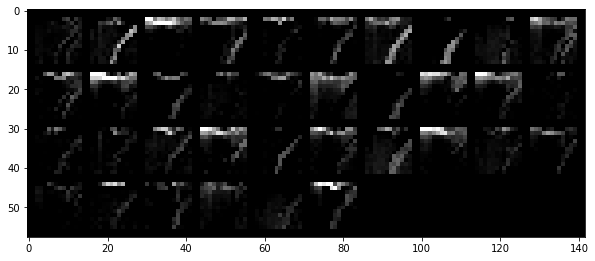

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


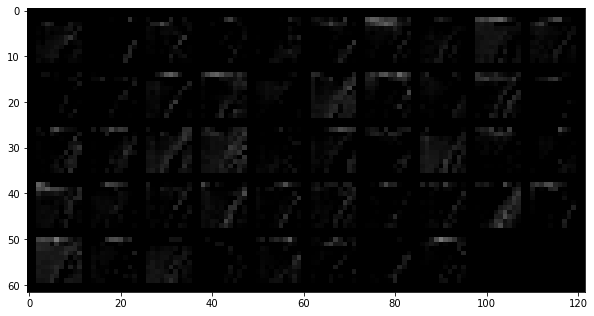

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


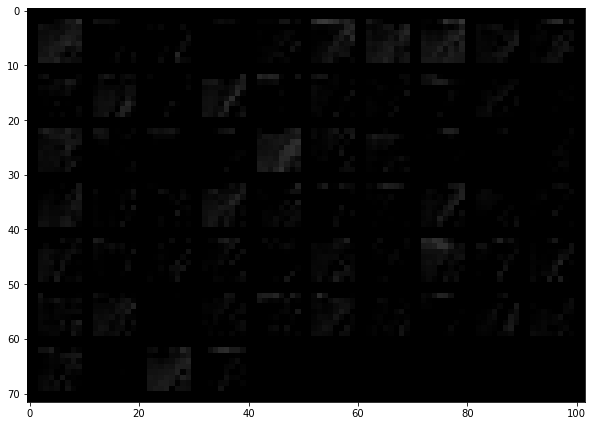

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


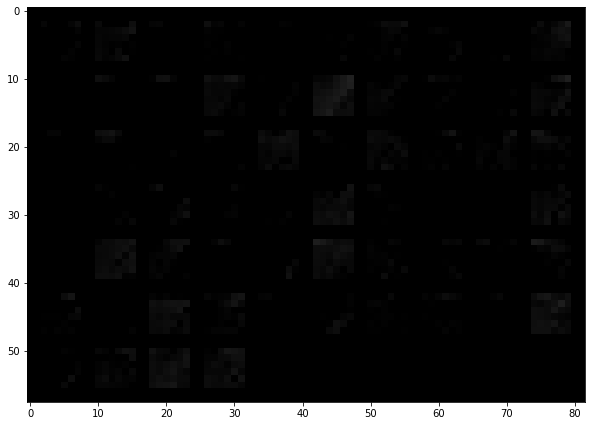

In [12]:
viz(network.c1)
viz(network.c2)
viz(network.c3)
viz(network.c4)
viz(network.c5)

#### Training one model

In [5]:
batch_size
ls=nn.MSELoss()
optimizer=optim.Adam(network.parameters(),lr=0.001)

for epoch in range(12):
    t_loss=0
    t_correct=0
    for batch in d_loader:
        
        images,acc,labels=batch
        images=images.reshape(images.shape[0],1,img_shape[0],img_shape[1]).to(device)
        labels=labels.to(device)

        preds=network(images)
        preds=preds.reshape(preds.shape[0])
        loss =ls(preds, labels)

        optimizer.zero_grad() ## avoid accumilation of gradients of previous loop
        loss.backward() ############# calcu late the gradients ########
        optimizer.step() ############ update the weight #########
        t_loss+=loss.item()
    if epoch==5:
            torch.save(network.state_dict(),"models/steer_set5_6ep_"+str(batch_size)+"_"+str(lr)+"_rsz_"+"pt4.pth")

    print("Epoch "+str(epoch)+">> "+"Total loss: "+str(t_loss), "Loss: "+ str(t_loss/data_len))

Epoch 0>> Total loss: 24.438604636117816 Loss: 0.0005077835072331661
Epoch 1>> Total loss: 13.401651952415705 Loss: 0.00027845852627193536
Epoch 2>> Total loss: 9.861758889630437 Loss: 0.00020490689182244093
Epoch 3>> Total loss: 6.627291794633493 Loss: 0.00013770137538716534
Epoch 4>> Total loss: 4.967256220988929 Loss: 0.00010320927985764896
Epoch 5>> Total loss: 3.665224027587101 Loss: 7.615575190298996e-05
Epoch 6>> Total loss: 10.278819564497098 Loss: 0.00021357254746711058
Epoch 7>> Total loss: 3.4122979642124847 Loss: 7.09004729931118e-05
Epoch 8>> Total loss: 2.227741877315566 Loss: 4.6287854831191116e-05
Epoch 9>> Total loss: 1.7975607890402898 Loss: 3.734958421376932e-05
Epoch 10>> Total loss: 1.3071467211120762 Loss: 2.7159797230553446e-05
Epoch 11>> Total loss: 2.146017165214289 Loss: 4.45897848490336e-05


#### Saving Network

In [6]:
torch.save(network.state_dict(),"models/steer_set5_12ep_"+str(batch_size)+"_"+str(lr)+"_rsz_"+"pt4.pth")

#### Test data prediction

In [15]:
data_len,d_loader=load_pt("D:/git/jetracer/set_4/pt_acc/set_4_test_rsz_withacc.pt","test") # either train or test (to save RAM)
images,labels=next(iter(d_loader))
sample,img_shape=sample_from_batch(images)

In [16]:
def all_prediction(model,loader):
    all_pred=torch.tensor([]).to(device)
    all_labels=torch.tensor([]).to(device)
    for batch in loader:
        images,labels=batch
        images=images.reshape(images.shape[0],1,img_shape[0],img_shape[0]).to(device)
        labels=labels.to(device)
        preds=model(images)
        preds=preds.reshape(preds.shape[0])
        
        all_labels=torch.cat((all_labels,labels),dim=0)
        all_pred=torch.cat((all_pred,preds),dim=0)
    return all_pred,all_labels

In [17]:
with torch.no_grad():
    train_preds,labels=all_prediction(network,d_loader)

In [11]:
error=[]
for val in range(train_preds.shape[0]):
    error.append((train_preds[val]-labels[val])**2)
mse=np.sum(error)/len(error)
print("MSE of test data: "+ str(mse))

MSE of test data: tensor(0.0037, device='cuda:0')


####  Single prediction visualization 

torch.Size([1, 1, 112, 112])
tensor([[-0.4973]], grad_fn=<AddmmBackward>)
tensor(-0.4350)


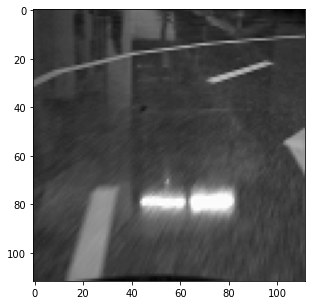

In [26]:
network_cpu=network.to("cpu")
batch=next(iter(d_loader))
img,lab=batch
img=img.reshape(batch_size,1,img_shape[0],img_shape[0])
img=img[0].unsqueeze(0)
print(img.shape)
print(network_cpu(img))
plt.figure(figsize=(5,5))
plt.imshow(img.squeeze(),cmap='gray')
print(lab[0])

#### Test saved model

In [92]:
network = Network().to(device)
network.load_state_dict(torch.load("set_1_7epoch.pth"))

<All keys matched successfully>

## Train multiple models

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from skimage import color
from torch.utils.tensorboard import SummaryWriter
print("Torch version: "+str(torch.__version__))
print("Current device: "+str(torch.cuda.current_device()))
print("Is cuda available? "+str(torch.cuda.is_available()))

if torch.cuda.is_available():
    device =torch.device('cuda')
    print("Running on the GPU")
else:
    device=torch.device("cpu")
    print("Running on the CPU")
img_shape=112

Torch version: 1.4.0
Current device: 0
Is cuda available? True
Running on the GPU


In [8]:
train_data=torch.load("D:/git/jetracer/set_3/pt_acc/set_3_train_rsz_withacc.pt")

In [2]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.norm = nn.LayerNorm(normalized_shape=(112,112))
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=24, kernel_size=3,stride=2)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=36, kernel_size=3,stride=1)
        self.conv3 = nn.Conv2d(in_channels=36, out_channels=48, kernel_size=3,stride=1)
        self.conv4 = nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.drop=nn.Dropout(0.5)

        self.fc1 = nn.Linear(in_features=64*6*6, out_features=1000)
        self.fc2 = nn.Linear(in_features=1000, out_features=500)
        self.fc3 = nn.Linear(in_features=500, out_features=100)
        self.fc4 = nn.Linear(in_features=100, out_features=10)
        self.out = nn.Linear(in_features=10, out_features=1)

    def forward(self, t):
        t=self.norm(t.float())
        self.nor=t
        
        t = F.elu(self.conv1(t.float()))
        t = F.max_pool2d(t, kernel_size=2)
        self.c1=t
        
        t = F.elu(self.conv2(t))
        t = F.max_pool2d(t, kernel_size=2)
        self.c2=t
        
        
        t = F.elu(self.conv3(t))
        self.c3=t


        t = F.elu(self.conv4(t))
        self.c4=t
        t = F.elu(self.conv5(t))
        self.c5=t
        t=self.drop(t)
        t=t.reshape(-1,t.shape[1]*t.shape[2]*t.shape[3])
        t=F.elu(self.fc1(t))
        t=F.elu(self.fc2(t))
        t=F.elu(self.fc3(t))
        t=F.elu(self.fc4(t))
        t=self.out(t)
        return t

In [10]:
batch_size_list=[100, 300, 600]
lr_list = [0.01,0.001,0.0001]
control=["steer","acc"]

In [11]:
print(device)
d_set=5
for cont in control:
    for batch_size in batch_size_list:
        for lr in lr_list:
            torch.cuda.empty_cache()
            network = Network().to(device)

            train_loader=torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
            optimizer = optim.Adam(network.parameters(), lr=lr)
            ls=nn.MSELoss()

            images,acc, labels = next(iter(train_loader))
            images=images.reshape(batch_size,1,images.shape[3],images.shape[3])
            grid = torchvision.utils.make_grid(images)

            comment=f' batch_size={batch_size} lr={lr}'
            tb = SummaryWriter(comment=comment)
            tb.add_image('images', grid.to(device))
            tb.add_graph(network, images.to(device))

            for epoch in range(18):
                total_loss = 0
                total_correct = 0
                for batch in train_loader:
                    images,acc,labels=batch
                    images=images.reshape(images.shape[0],1,img_shape,img_shape).to(device)
                    if cont=="steer":
                        labels=labels.to(device)
                        preds=network(images)
                        preds=preds.reshape(preds.shape[0])
                        loss =ls(preds, labels)
                    elif cont=="acc":
                        acc=acc.to(device)
                        preds=network(images)
                        preds=preds.reshape(preds.shape[0])
                        loss =ls(preds, acc)

                    optimizer.zero_grad() ## avoid accumilation of gradients of previous loop
                    loss.backward() ############# calcu late the gradients ########
                    optimizer.step() ############ update the weight #########
                    total_loss+=loss.item()

                tb.add_scalar('Loss', total_loss, epoch)
                for name, param in network.named_parameters():
                    tb.add_histogram(name, param, epoch)
                    tb.add_histogram(f'{name}.grad', param.grad, epoch)
                if epoch==5:
                    torch.save(network.state_dict(),"models/"+str(cont)+"_set"+str(d_set)+"_6ep_"+str(batch_size)+"_"+str(lr)+"_rsz_"+"pt4.pth")
                elif epoch==11:
                    torch.save(network.state_dict(),"models/"+str(cont)+"_set"+str(d_set)+"_12ep_"+str(batch_size)+"_"+str(lr)+"_rsz_"+"pt4.pth")

                print("epoch", epoch ,"Total loss:", total_loss,"loss:",total_loss/len(train_data) )
                torch.save(network.state_dict(),"models/"+str(cont)+"_set"+str(d_set)+"_18ep_"+str(batch_size)+"_"+str(lr)+"_rsz_"+"pt4.pth")
            print("Next comb")
            tb.close()

cuda
epoch 0 Total loss: 96169.69064951688 loss: 2.059660983669941
epoch 1 Total loss: 70.52219194918871 loss: 0.0015103699123873192
epoch 2 Total loss: 70.10305799543858 loss: 0.0015013933435157752
epoch 3 Total loss: 70.05247563868761 loss: 0.001500310023958871
epoch 4 Total loss: 70.05468511581421 loss: 0.0015003573442091624
epoch 5 Total loss: 70.06137754023075 loss: 0.00150050067549539
epoch 6 Total loss: 70.04674941301346 loss: 0.0015001873856980523
epoch 7 Total loss: 70.02128406614065 loss: 0.0014996419957624572
epoch 8 Total loss: 69.53402899950743 loss: 0.0014892064807570339
epoch 9 Total loss: 65.59213667362928 loss: 0.0014047831892750212
epoch 10 Total loss: 62.380318343639374 loss: 0.0013359958524723587
epoch 11 Total loss: 63.71393747627735 loss: 0.001364557900202976
epoch 12 Total loss: 70.08799155056477 loss: 0.0015010706662932573
epoch 13 Total loss: 70.08915627747774 loss: 0.0015010956111855937
epoch 14 Total loss: 70.09606339037418 loss: 0.0015012435404432062
epoch 1

epoch 14 Total loss: 10.037771545350552 loss: 0.00021497840198215007
epoch 15 Total loss: 9.555110678076744 loss: 0.00020464128069212594
epoch 16 Total loss: 9.398200526833534 loss: 0.00020128074459936464
epoch 17 Total loss: 9.334268502891064 loss: 0.00019991151595329101
Next comb
epoch 0 Total loss: 5.268658265471458 loss: 0.00011283856475352219
epoch 1 Total loss: 1.3535481747239828 loss: 2.898886693060873e-05
epoch 2 Total loss: 1.0221251277253032 loss: 2.189079773248743e-05
epoch 3 Total loss: 0.7627461017109454 loss: 1.633569137563063e-05
epoch 4 Total loss: 0.6762173776514828 loss: 1.448251044400503e-05
epoch 5 Total loss: 0.6218595136888325 loss: 1.3318331056472897e-05
epoch 6 Total loss: 0.6039607669226825 loss: 1.293499457985699e-05
epoch 7 Total loss: 0.5371269206516445 loss: 1.1503617764320322e-05
epoch 8 Total loss: 0.492086133453995 loss: 1.0538981698235137e-05
epoch 9 Total loss: 0.4890048364177346 loss: 1.0472989728812958e-05
epoch 10 Total loss: 0.4494491401128471 loss

epoch 8 Total loss: 0.08476278293528594 loss: 1.8153598675423186e-06
epoch 9 Total loss: 0.08095573034370318 loss: 1.7338244312452493e-06
epoch 10 Total loss: 0.07908962675719522 loss: 1.6938581932064425e-06
epoch 11 Total loss: 0.07827137791900896 loss: 1.6763338027715445e-06
epoch 12 Total loss: 0.0761840308259707 loss: 1.6316292047025336e-06
epoch 13 Total loss: 0.07171978376572952 loss: 1.5360186705587577e-06
epoch 14 Total loss: 0.0701605704089161 loss: 1.5026250837170414e-06
epoch 15 Total loss: 0.06681342830415815 loss: 1.4309395250612128e-06
epoch 16 Total loss: 0.06495197315234691 loss: 1.3910728422930462e-06
epoch 17 Total loss: 0.06369971079402603 loss: 1.3642532081304298e-06
Next comb
epoch 0 Total loss: 0.38736596144735813 loss: 8.296195524872743e-06
epoch 1 Total loss: 0.09769524552393705 loss: 2.092333708642531e-06
epoch 2 Total loss: 0.09443365520564839 loss: 2.0224804078996056e-06
epoch 3 Total loss: 0.09224458993412554 loss: 1.9755973171876454e-06
epoch 4 Total loss: 

## Test_data

In [3]:
def all_prediction(model,loader,typ):
    all_pred=torch.tensor([]).to(device)
    all_labels=torch.tensor([]).to(device)
    for batch in loader:
        images,acc,labels=batch
        images=images.reshape(images.shape[0],1,img_shape[0],img_shape[0]).to(device)
        labels=labels.to(device)
        acc=acc.to(device)
        preds=model(images)
        preds=preds.reshape(preds.shape[0])
        if typ=="steer":
            all_labels=torch.cat((all_labels,labels),dim=0)
        elif typ=="acc":
            all_labels=torch.cat((all_labels,acc),dim=0)
        all_pred=torch.cat((all_pred,preds),dim=0)
    return all_pred,all_labels

In [8]:
import os
directory = r'D:/git/jetracer/set_3/set_3_models'
text_file = open("D:/git/jetracer/set_3/test_result.txt", "w")
data_len,d_loader=load_pt("D:/git/jetracer/set_3/pt_acc/set_3_test_rsz_withacc.pt","test") # either train or test (to save RAM)
images,acc,labels=next(iter(d_loader))
sample,img_shape=sample_from_batch(images)
for filename in os.listdir(directory):
    network=Network().to(device)    
    network.load_state_dict(torch.load('D:/git/jetracer/set_3/set_3_models/'+filename))
    if filename[0]=="s":
        with torch.no_grad():
            train_preds,labels=all_prediction(network,d_loader,"steer")
        error=[]
        for val in range(train_preds.shape[0]):
            error.append((train_preds[val]-labels[val])**2)
        mse=np.sum(error)/len(error)
        print("MSE of test data: "+ str(mse))
        n = text_file.write(filename+"    MSE  >>>>"+str(mse)+"\n")
    else:
        with torch.no_grad():
            train_preds,labels=all_prediction(network,d_loader,"acc")
        error=[]
        for val in range(train_preds.shape[0]):
            error.append((train_preds[val]-labels[val])**2)
        mse=np.sum(error)/len(error)
        print("MSE of test data: "+ str(mse))
        n = text_file.write(filename+"     MSE  >>>>"+str(mse)+"\n")
text_file.close()

MSE of test data: tensor(0.0003, device='cuda:0')
MSE of test data: tensor(0.0002, device='cuda:0')
MSE of test data: tensor(0.0006, device='cuda:0')
MSE of test data: tensor(0.0005, device='cuda:0')
MSE of test data: tensor(0.0005, device='cuda:0')
MSE of test data: tensor(0.0007, device='cuda:0')
MSE of test data: tensor(0.0005, device='cuda:0')
MSE of test data: tensor(0.0005, device='cuda:0')
MSE of test data: tensor(0.0009, device='cuda:0')
MSE of test data: tensor(0.0002, device='cuda:0')
MSE of test data: tensor(0.0147, device='cuda:0')
MSE of test data: tensor(0.0006, device='cuda:0')
MSE of test data: tensor(0.0004, device='cuda:0')
MSE of test data: tensor(0.0004, device='cuda:0')
MSE of test data: tensor(0.0006, device='cuda:0')
MSE of test data: tensor(0.0005, device='cuda:0')
MSE of test data: tensor(0.0004, device='cuda:0')
MSE of test data: tensor(0.0007, device='cuda:0')
MSE of test data: tensor(0.0004, device='cuda:0')
MSE of test data: tensor(0.0003, device='cuda:0')
